In [1]:
#Important imports to be added

import pandas as pd
import numpy as np
!pip install swifter
import re,nltk,swifter
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=1e117a2d0aa424301f0b0680ce858045d53ff03238280ba2ee1292187f490e3d
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import nltk
#downloading stopwords library from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
#reading csv and filling out missing values
df = pd.read_csv(r'/content/drive/MyDrive/Final project/train-balanced-sarcasm.csv')
df = df.sample(n=10000, random_state=42)
df = df.fillna('')

In [9]:
#taking only necessary comments
df = df[['label','comment','author','score','created_utc','parent_comment']]

In [10]:
df.head()

,label,comment,author,score,created_utc,parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes)
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...


**Exploratory Data Analysis**

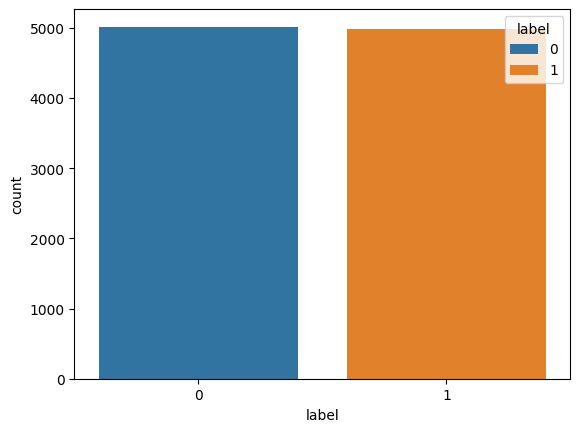

The percentage of Non-Sarcastic comments is 50.14999999999999
The percentage of Sarcastic comments is 49.85


In [11]:
import seaborn as sns
sns.countplot(x="label",data=df,hue="label")
plt.show()
print("The percentage of Non-Sarcastic comments is",sum(df['label']==0)/(len(df['label']))*100)
print("The percentage of Sarcastic comments is",sum(df['label']==1)/(len(df['label']))*100)

We can see from the countplot that this dataset is balanced

In [12]:
def clean_text(comment):

    # Cleaning the text by removing links, usernames, HTML tags, expansion of words, username removal, etc.
    text = str(comment)

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove HTML tags
    text = re.sub("<.*?>", " ", text)

    # Remove numbers
    text = re.sub(r"[0-9]+", " ", text)

    # Remove reddit handles
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)

    # Replace contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # Remove special characters
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')

    return text

# Apply text cleaning on comment and parent comment
df["cleanV1_comment"] = df["comment"].apply(clean_text)
df["cleanV1_parent_comment"] = df["parent_comment"].apply(clean_text)


In [13]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes)
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...


In [14]:
#function to lowercase all except all caps word
def lowercase_except_caps(sentence):
  #print(sentence)
  words = sentence.split()
  modified_words = []
  for word in words:
    if word.isupper():
      modified_words.append(word)
    else:
      modified_words.append(word.lower())
  return " ".join(modified_words)

**Abbreviation Replacement**


In [16]:
#csv to dataframe
abbrslang=pd.read_csv(r'/content/drive/MyDrive/Final project/Abbr.csv')
abbrslang

,Abbr,Meaning
0,@TEOTD,At the end of the day
1,143,I love you
2,2G2BT,Too good to be true
3,404,I don't know
4,4EAE,Forever and ever
...,...,...
426,BS,Bullshit
427,NYC,New York City
428,VR,Virtual Reality
429,GTA,Grand Theft Auto


In [17]:
abbrslangDict=abbrslang.to_dict(orient='records')

In [18]:
import re
def expand_abbr(text, abbr_dict):
    # Regex for 2 or more capital letters (excluding common abbreviations)
    pattern1 = r"\b([A-Z]{2,}(?!\.[A-Z]{2,}))\b"

    # Regex for common abbreviations (Mr., Mrs., etc.)
    pattern2 = r"\b([A-Z]{2,}\.?)\b"

    # Combine both patterns
    combined_pattern = re.compile("|".join([pattern1, pattern2]))

    detected_abbr = []  # List to store detected abbreviations

    def expand_match(match):
        matched_abbr = match.group()
        detected_abbr.append(matched_abbr)  # Store detected abbreviation
        for entry in abbr_dict:
            if matched_abbr.upper() == entry['Abbr']:
                return entry['Meaning']
        return matched_abbr  # Use default if not found

    if not isinstance(text, str):
        text = str(text)  # Convert non-string inputs to strings

    expanded_text = combined_pattern.sub(expand_match, text)

    return expanded_text, detected_abbr

df['abbr_comment'], df['detected_abbr'] = zip(*df['cleanV1_comment'].apply(expand_abbr, args=(abbrslangDict,)))
df['abbr_parent_comment'], df['detected_parent_abbr'] = zip(*df['cleanV1_parent_comment'].apply(expand_abbr, args=(abbrslangDict,)))
df.head(5)


,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,And he sure as hell is successful!,[],Obama is smoked before? Or at least admitted it?,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",[],You can say the same thing about any chess pla...,[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?,I mean how could anyone not see that it is ant...,[],That is not Hanako?,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",[],Girl Pants (X/post from TwoXChromosomes),[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Lyndon Johnson salad: A carrot and beetroots...,[]


In [20]:
from collections import Counter
import pandas as pd

# Flatten the list of lists from detected_abbr and detected_parent_abbr columns into separate lists
detected_abbr_flat = [word for sublist in df['detected_abbr'] if sublist for word in sublist]
detected_parent_abbr_flat = [word for sublist in df['detected_parent_abbr'] if sublist for word in sublist]

# Count the frequency of each word in detected_abbr and detected_parent_abbr
abbr_freq = Counter(detected_abbr_flat)
parent_abbr_freq = Counter(detected_parent_abbr_flat)

# Convert the Counter objects to DataFrames
abbr_freq_df = pd.DataFrame.from_dict(abbr_freq, orient='index', columns=['abbr_comment_freq'])
parent_abbr_freq_df = pd.DataFrame.from_dict(parent_abbr_freq, orient='index', columns=['parent_abbr_comment_freq'])

# Reset the index to make the 'word' a column
abbr_freq_df.reset_index(inplace=True)
parent_abbr_freq_df.reset_index(inplace=True)

# Rename the 'index' column to 'comment_abbr' and 'parent_comment_abbr'
abbr_freq_df.rename(columns={'index': 'comment_abbr'}, inplace=True)
parent_abbr_freq_df.rename(columns={'index': 'parent_comment_abbr'}, inplace=True)

# Save the DataFrames to a CSV file
output_df = pd.concat([abbr_freq_df, parent_abbr_freq_df], axis=1)
output_df.to_csv('/content/drive/MyDrive/Final project/Abbr_word_frequency.csv', index=False)

In [22]:
df.to_csv('/content/drive/MyDrive/Final project/Abbr_log.csv', index=False)

In [23]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,And he sure as hell is successful!,[],Obama is smoked before? Or at least admitted it?,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",[],You can say the same thing about any chess pla...,[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?,I mean how could anyone not see that it is ant...,[],That is not Hanako?,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",[],Girl Pants (X/post from TwoXChromosomes),[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Lyndon Johnson salad: A carrot and beetroots...,[]


# Slang Handling

In [25]:
import pandas as pd

# Load the CSV file into a DataFrame
slangs_df = pd.read_csv('/content/drive/MyDrive/Final project/Slangs.csv')

# Create a dictionary from the DataFrame
slangs_dict = dict(zip(slangs_df['slangs'], slangs_df['meanings']))

# Function to replace slangs in a sentence and store detected slangs
def replace_slangs(sentence):
    words = sentence.split()
    replaced_words = []
    detected_slangs = []
    for word in words:
        meaning = slangs_dict.get(word, word)
        if meaning != word:
            detected_slangs.append((word, meaning))
        replaced_words.append(meaning)
    return ' '.join(replaced_words), detected_slangs

df['slang_comment'], df['detected_slangs'] = zip(*df['abbr_comment'].apply(replace_slangs))
df['slang_parent_comment'], df['detected_parent_slangs'] = zip(*df['abbr_parent_comment'].apply(replace_slangs))

# Display the updated DataFrame
df.tail(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr,slang_comment,detected_slangs,slang_parent_comment,detected_parent_slangs
912509,1,"Thanks, that cleared it up.",Rtwk,9,2013-10-26 19:19:51,Sat at a police station for a few hours. Came ...,"Thanks, that cleared it up.",Sat at a police station for a few hours. Came ...,"Thanks, that cleared it up.",[],Sat at a police station for a few hours. Came ...,[],"Thanks, that cleared it up.",[],Sat at a police station for a few hours. Came ...,[]
899860,0,he's so cute that you could hardly believe he'...,smurgleburf,1,2014-06-15 20:21:51,Bears eat dirt and moss to plug their system s...,he is so cute that you could hardly believe he...,Bears eat dirt and moss to plug their system s...,he is so cute that you could hardly believe he...,[],Bears eat dirt and moss to plug their system s...,[],he is so cute that you could hardly believe he...,[],Bears eat dirt and moss to plug their system s...,[]
89881,1,But... But... he went bankrupt!,CanIGetAc,1,2016-09-07 04:16:56,"When asked ""What would you do for a million do...",But... But... he went bankrupt!,"When asked ""What would you do for a million do...",But... But... he went bankrupt!,[],"When asked ""What would you do for a million do...",[],But... But... he went bankrupt!,[],"When asked ""What would you do for a million do...",[]
978690,1,Sodom and Gamora.,pi_over_3,1,2012-03-21 20:05:33,"Shhh! Don't tell people, or they will start ya...",Sodom and Gamora.,"Shhh! Do not tell people, or they will start y...",Sodom and Gamora.,[],"Shhh! Do not tell people, or they will start y...",[],Sodom and Gamora.,[],"Shhh! Do not tell people, or they will start y...",[]
687283,0,I take some small comfort in the fact this man...,Biffingston,1,2015-04-03 18:48:09,Arnold Schwarzenegger 'Furious' Over GOP Suppo...,I take some small comfort in the fact this man...,Arnold Schwarzenegger 'Furious' Over GOP Suppo...,I take some small comfort in the fact this man...,[],Arnold Schwarzenegger 'Furious' Over GOP Suppo...,[GOP],I take some small comfort in the fact this man...,[],Arnold Schwarzenegger 'Furious' Over GOP Suppo...,[]
989368,0,And the drop-bears... can't forget those fuzzy...,Bcteagirl,1,2011-10-27 20:09:03,That's why the food is expensive. The farmer's...,And the drop-bears... can not forget those fuz...,That is why the food is expensive. The farmer ...,And the drop-bears... can not forget those fuz...,[],That is why the food is expensive. The farmer ...,[],And the drop-bears... can not forget those fuz...,[],That is why the food is expensive. The farmer ...,[]
292333,0,o7 Hail!,AvalonTreman,4,2016-07-03 19:36:19,"Another Avalon! Hail, brother.",o Hail!,"Another Avalon! Hail, brother.",o Hail!,[],"Another Avalon! Hail, brother.",[],o Hail!,[],"Another Avalon! Hail, brother.",[]
546581,1,3,tangemann,4,2015-08-04 19:31:59,"On a scale of one to Gaben, how empty is your ...",,"On a scale of one to Gaben, how empty is your ...",,[],"On a scale of one to Gaben, how empty is your ...",[],,[],"On a scale of one to Gaben, how empty is your ...",[]
936260,1,Repetitive fire hydrant and trash can placing ...,UsedCheese,43,2013-08-02 16:16:11,Screenshot Analysis,Repetitive fire hydrant and trash can placing ...,Screenshot Analysis,Repetitive fire hydrant and trash can placing ...,[],Screenshot Analysis,[],Repetitive fire hydrant and trash can placing ...,[],Screenshot Analysis,[]
784034,1,Golden corral.,Beersaround,1,2015-06-22 14:52:30,My grandparents are coming to visit Indianapol...,Golden corral.,My grandparents are coming to visit Indianapol...,Golden corral.,[],My grandparents are coming to visit Indianapol...,[],Golden corral.,[],My grandparents are coming to visit Indianapol...,[]


In [27]:
from collections import Counter
import pandas as pd

# Flatten the list of lists from detected_slangs and detected_parent_slangs columns into separate lists
detected_slang_flat = [word for sublist in df['detected_slangs'] if sublist for word in sublist]
detected_parent_slang_flat = [word for sublist in df['detected_parent_slangs'] if sublist for word in sublist]

# Count the frequency of each word in detected_slangs and detected_parent_slangs
slang_freq = Counter(detected_slang_flat)
parent_slang_freq = Counter(detected_parent_slang_flat)

# Convert the Counter objects to DataFrames
slang_freq_df = pd.DataFrame.from_dict(slang_freq, orient='index', columns=['slang_comment_freq'])
parent_slang_freq_df = pd.DataFrame.from_dict(parent_slang_freq, orient='index', columns=['parent_slang_comment_freq'])

# Reset the index to make the 'word' a column
slang_freq_df.reset_index(inplace=True)
parent_slang_freq_df.reset_index(inplace=True)

# Rename the 'index' column to 'comment_slangs' and 'parent_comment_slangs'
slang_freq_df.rename(columns={'index': 'comment_slangs'}, inplace=True)
parent_slang_freq_df.rename(columns={'index': 'parent_comment_slangs'}, inplace=True)

# Save the DataFrames to a CSV file
output_df = pd.concat([slang_freq_df, parent_slang_freq_df], axis=1)
output_df.to_csv('/content/drive/MyDrive/Final project/Slang_word_frequency.csv', index=False)

In [28]:
df.to_csv('/content/drive/MyDrive/Final project/Slang_log.csv', index=False)

In [29]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr,slang_comment,detected_slangs,slang_parent_comment,detected_parent_slangs
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,And he sure as hell is successful!,[],Obama is smoked before? Or at least admitted it?,[],And he sure as hell is successful!,[],Obama is smoked before? Or at least admitted it?,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",[],You can say the same thing about any chess pla...,[],"wait, you have to win the candidates to challe...",[],You can say the same thing about any chess pla...,[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?,I mean how could anyone not see that it is ant...,[],That is not Hanako?,[],I mean how could anyone not see that it is ant...,[],That is not Hanako?,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",[],Girl Pants (X/post from TwoXChromosomes),[],"Funny thing, most of the girl pants I have bou...",[],Girl Pants (X/post from TwoXChromosomes),[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Lyndon Johnson salad: A carrot and beetroots...,[],"Also Ranch dressing, because LBJ was Texan, an...",[],Lyndon Johnson salad: A carrot and beetroots i...,[]


In [30]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string

# Remove punctuation marks
df['punct_comment'] = df['slang_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation or char in ['?', '!','...']]))
df['punct_parent_comment'] = df['slang_parent_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation or char in ['?', '!','...']]))
# Tokenize the text
df['tokenized_comment'] = df['punct_comment'].apply(lambda x: word_tokenize(x))
df['tokenized_parent_comment'] = df['punct_parent_comment'].apply(lambda x: word_tokenize(x))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [31]:
df.head(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr,slang_comment,detected_slangs,slang_parent_comment,detected_parent_slangs,punct_comment,punct_parent_comment,tokenized_comment,tokenized_parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,And he sure as hell is successful!,[],Obama is smoked before? Or at least admitted it?,[],And he sure as hell is successful!,[],Obama is smoked before? Or at least admitted it?,[],And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,"[And, he, sure, as, hell, is, successful, !]","[Obama, is, smoked, before, ?, Or, at, least, ..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",[],You can say the same thing about any chess pla...,[],"wait, you have to win the candidates to challe...",[],You can say the same thing about any chess pla...,[],wait you have to win the candidates to challen...,You can say the same thing about any chess pla...,"[wait, you, have, to, win, the, candidates, to...","[You, can, say, the, same, thing, about, any, ..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?,I mean how could anyone not see that it is ant...,[],That is not Hanako?,[],I mean how could anyone not see that it is ant...,[],That is not Hanako?,[],I mean how could anyone not see that it is ant...,That is not Hanako?,"[I, mean, how, could, anyone, not, see, that, ...","[That, is, not, Hanako, ?]"
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",[],Girl Pants (X/post from TwoXChromosomes),[],"Funny thing, most of the girl pants I have bou...",[],Girl Pants (X/post from TwoXChromosomes),[],Funny thing most of the girl pants I have boug...,Girl Pants Xpost from TwoXChromosomes,"[Funny, thing, most, of, the, girl, pants, I, ...","[Girl, Pants, Xpost, from, TwoXChromosomes]"
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Lyndon Johnson salad: A carrot and beetroots...,[],"Also Ranch dressing, because LBJ was Texan, an...",[],Lyndon Johnson salad: A carrot and beetroots i...,[],Also Ranch dressing because LBJ was Texan and ...,Lyndon Johnson salad A carrot and beetroots in...,"[Also, Ranch, dressing, because, LBJ, was, Tex...","[Lyndon, Johnson, salad, A, carrot, and, beetr..."
951335,0,Being adorable.,ParisPC07,3,2013-10-16 19:21:43,What is this little red spider doing?,Being adorable.,What is this little red spider doing?,Being adorable.,[],What is this little red spider doing?,[],Being adorable.,[],What is this little red spider doing?,[],Being adorable,What is this little red spider doing?,"[Being, adorable]","[What, is, this, little, red, spider, doing, ?]"
655372,0,git-annex works like crap on windows.,zouhair,1,2015-04-09 19:39:56,I wonder why they invented their own instead o...,git-annex works like crap on windows.,I wonder why they invented their own instead o...,git-annex works like crap on windows.,[],I wonder why they invented their own ins

In [32]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 6.8 MB/s eta 0:00:00


In [33]:
import emoji
# Function to check if a string contains emojis
def has_emoji(text):
    #text = str(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

# Function to replace emojis with their meanings
def replace_emojis(text):
    return emoji.demojize(text)

# Apply emoji replacement and check for emojis
df["has_emoji"] = df["tokenized_comment"].astype(str).apply(has_emoji)
df["has_emoji_parent"] = df["tokenized_parent_comment"].astype(str).apply(has_emoji)

# Apply emoji replacement and create a pandas Series
emoji_replaced_series = df["tokenized_comment"].astype(str).apply(replace_emojis)
emoji_replaced_series_parent = df["tokenized_parent_comment"].astype(str).apply(replace_emojis)

# Assign the pandas Series to the DataFrame as a new column
df["emoji_replaced_comment"] = emoji_replaced_series
df["emoji_replaced_parent_comment"] = emoji_replaced_series_parent
print(type(df['emoji_replaced_comment']))
print(type(df['emoji_replaced_parent_comment']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [34]:
print(df['has_emoji'].value_counts()[False])
print(df['has_emoji_parent'].value_counts()[False])

10000
10000


**This upper value is same as the total number of comments, which shows that we don't have any emojis in the dataset**

In [35]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,slang_parent_comment,detected_parent_slangs,punct_comment,punct_parent_comment,tokenized_comment,tokenized_parent_comment,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,And he sure as hell is successful!,[],...,Obama is smoked before? Or at least admitted it?,[],And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,"[And, he, sure, as, hell, is, successful, !]","[Obama, is, smoked, before, ?, Or, at, least, ...",False,False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","['Obama', 'is', 'smoked', 'before', '?', 'Or',..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",[],...,You can say the same thing about any chess pla...,[],wait you have to win the candidates to challen...,You can say the same thing about any chess pla...,"[wait, you, have, to, win, the, candidates, to...","[You, can, say, the, same, thing, about, any, ...",False,False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","['You', 'can', 'say', 'the', 'same', 'thing', ..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?,I mean how could anyone not see that it is ant...,[],...,That is not Hanako?,[],I mean how could anyone not see that it is ant...,That is not Hanako?,"[I, mean, how, could, anyone, not, see, that, ...","[That, is, not, Hanako, ?]",False,False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","['That', 'is', 'not', 'Hanako', '?']"
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",[],...,Girl Pants (X/post from TwoXChromosomes),[],Funny thing most of the girl pants I have boug...,Girl Pants Xpost from TwoXChromosomes,"[Funny, thing, most, of, the, girl, pants, I, ...","[Girl, Pants, Xpost, from, TwoXChromosomes]",False,False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","['Girl', 'Pants', 'Xpost', 'from', 'TwoXChromo..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",[LBJ],...,Lyndon Johnson salad: A carrot and beetroots i...,[],Also Ranch dressing because LBJ was Texan and ...,Lyndon Johnson salad A carrot and beetroots in...,"[Also, Ranch, dressing, because, LBJ, was, Tex...","[Lyndon, Johnson, salad, A, carrot, and, beetr...",False,False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","['Lyndon', 'Johnson', 'salad', 'A', 'carrot', ..."


**Lowercasing the tokenized comments and parent comments**

In [36]:
# Apply the lowercase_except_caps function to 'emoji_replaced_comment' column
df['lowered_comment'] = df['emoji_replaced_comment'].apply(lowercase_except_caps)

# Apply the lowercase_except_caps function to 'emoji_replaced_parent_comment' column
df['lowered_parent_comment'] = df['emoji_replaced_parent_comment'].apply(lowercase_except_caps)

In [37]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,punct_comment,punct_parent_comment,tokenized_comment,tokenized_parent_comment,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,And he sure as hell is successful!,[],...,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,"[And, he, sure, as, hell, is, successful, !]","[Obama, is, smoked, before, ?, Or, at, least, ...",False,False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","['Obama', 'is', 'smoked', 'before', '?', 'Or',...","['and', 'he', 'sure', 'as', 'hell', 'is', 'suc...","['obama', 'is', 'smoked', 'before', '?', 'or',..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",[],...,wait you have to win the candidates to challen...,You can say the same thing about any chess pla...,"[wait, you, have, to, win, the, candidates, to...","[You, can, say, the, same, thing, about, any, ...",False,False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","['You', 'can', 'say', 'the', 'same', 'thing', ...","['wait', 'you', 'have', 'to', 'win', 'the', 'c...","['you', 'can', 'say', 'the', 'same', 'thing', ..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?,I mean how could anyone not see that it is ant...,[],...,I mean how could anyone not see that it is ant...,That is not Hanako?,"[I, mean, how, could, anyone, not, see, that, ...","[That, is, not, Hanako, ?]",False,False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","['That', 'is', 'not', 'Hanako', '?']","['I', 'mean', 'how', 'could', 'anyone', 'not',...","['that', 'is', 'not', 'hanako', '?']"
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",[],...,Funny thing most of the girl pants I have boug...,Girl Pants Xpost from TwoXChromosomes,"[Funny, thing, most, of, the, girl, pants, I, ...","[Girl, Pants, Xpost, from, TwoXChromosomes]",False,False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","['Girl', 'Pants', 'Xpost', 'from', 'TwoXChromo...","['funny', 'thing', 'most', 'of', 'the', 'girl'...","['girl', 'pants', 'xpost', 'from', 'twoxchromo..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",[LBJ],...,Also Ranch dressing because LBJ was Texan and ...,Lyndon Johnson salad A carrot and beetroots in...,"[Also, Ranch, dressing, because, LBJ, was, Tex...","[Lyndon, Johnson, salad, A, carrot, and, beetr...",False,False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","['Lyndon', 'Johnson', 'salad', 'A', 'carrot', ...","['also', 'ranch', 'dressing', 'because', 'LBJ'...","['lyndon', 'johnson', 'salad', 'A', 'carrot', ..."


**Stop words removal**

In [38]:
import ast
from nltk.corpus import stopwords

# Import stopwords and define custom set
stops = set(stopwords.words('english')) - {'no', 'not', 'nor', 'against', 'above', 'below', 'off', 'own'}

# Apply stopword removal to the emoji_replaced_comment column
def remove_stopwords(comment):
    return [word for word in ast.literal_eval(comment) if word.lower() not in stops]

df["cleaned_comment"] = df["lowered_comment"].apply(remove_stopwords)
df["cleaned_parent_comment"] = df["lowered_parent_comment"].apply(remove_stopwords)

In [39]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,tokenized_comment,tokenized_parent_comment,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment,cleaned_comment,cleaned_parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,And he sure as hell is successful!,[],...,"[And, he, sure, as, hell, is, successful, !]","[Obama, is, smoked, before, ?, Or, at, least, ...",False,False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","['Obama', 'is', 'smoked', 'before', '?', 'Or',...","['and', 'he', 'sure', 'as', 'hell', 'is', 'suc...","['obama', 'is', 'smoked', 'before', '?', 'or',...","[sure, hell, successful, !]","[obama, smoked, ?, least, admitted, ?]"
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",[],...,"[wait, you, have, to, win, the, candidates, to...","[You, can, say, the, same, thing, about, any, ...",False,False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","['You', 'can', 'say', 'the', 'same', 'thing', ...","['wait', 'you', 'have', 'to', 'win', 'the', 'c...","['you', 'can', 'say', 'the', 'same', 'thing', ...","[wait, win, candidates, challenge, world, titl...","[say, thing, chess, player, end, day, win, can..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?,I mean how could anyone not see that it is ant...,[],...,"[I, mean, how, could, anyone, not, see, that, ...","[That, is, not, Hanako, ?]",False,False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","['That', 'is', 'not', 'Hanako', '?']","['I', 'mean', 'how', 'could', 'anyone', 'not',...","['that', 'is', 'not', 'hanako', '?']","[mean, could, anyone, not, see, antique, shopguy]","[not, hanako, ?]"
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",[],...,"[Funny, thing, most, of, the, girl, pants, I, ...","[Girl, Pants, Xpost, from, TwoXChromosomes]",False,False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","['Girl', 'Pants', 'Xpost', 'from', 'TwoXChromo...","['funny', 'thing', 'most', 'of', 'the', 'girl'...","['girl', 'pants', 'xpost', 'from', 'twoxchromo...","[funny, thing, girl, pants, bought, pretty, go...","[girl, pants, xpost, twoxchromosomes]"
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",[LBJ],...,"[Also, Ranch, dressing, because, LBJ, was, Tex...","[Lyndon, Johnson, salad, A, carrot, and, beetr...",False,False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","['Lyndon', 'Johnson', 'salad', 'A', 'carrot', ...","['also', 'ranch', 'dressing', 'because', 'LBJ'...","['lyndon', 'johnson', 'salad', 'A', 'carrot', ...","[also, ranch, dressing, LBJ, texan, not, take,...","[lyndon, johnson, salad, carrot, beetroots, sh..."


**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories before cleaning**

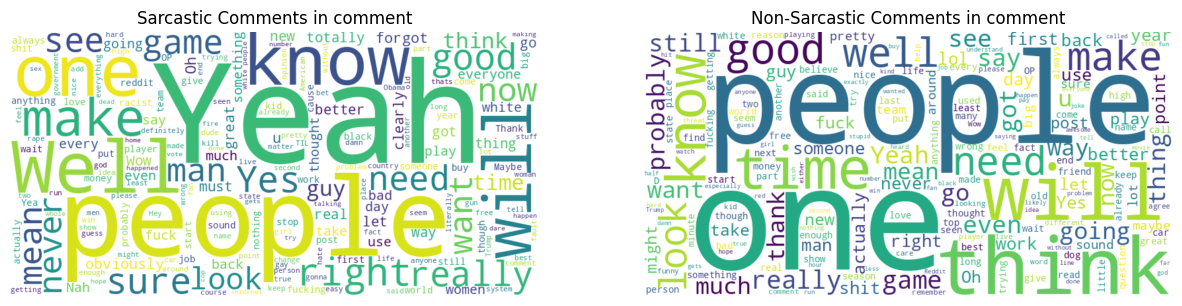

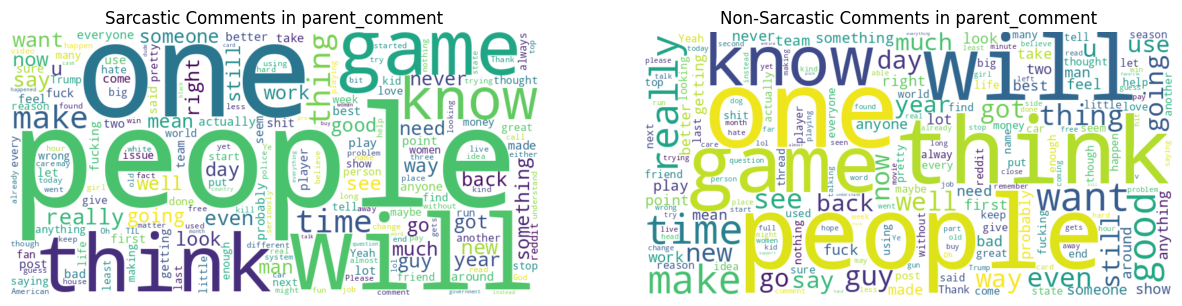

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter sarcastic and non-sarcastic comments in 'comment' column
sarcastic_comments = ' '.join(df[df['label'] == 1]['comment'])
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['comment'])

# Generate word clouds for sarcastic and non-sarcastic comments in 'comment' column
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds for 'comment'
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments in comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in comment')
plt.axis('off')

plt.show()

# Filter sarcastic and non-sarcastic comments in 'parent_comment' column
sarcastic_parent_comments = ' '.join(df[df['label'] == 1]['parent_comment'])
non_sarcastic_parent_comments = ' '.join(df[df['label'] == 0]['parent_comment'])

# Generate word clouds for sarcastic and non-sarcastic comments in 'parent_comment' column
wordcloud_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_parent_comments)
wordcloud_non_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_parent_comments)

# Plot the word clouds for 'parent_comment'
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic_parent, interpolation='bilinear')
plt.title('Sarcastic Comments in parent_comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic_parent, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in parent_comment')
plt.axis('off')

plt.show()

**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories after cleaning**

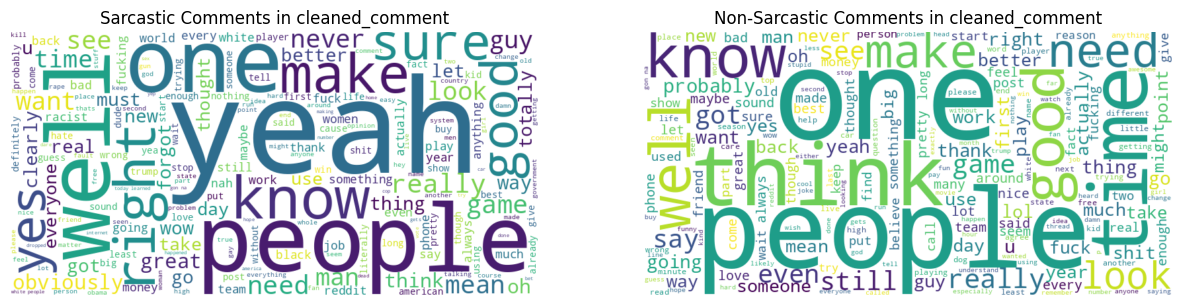

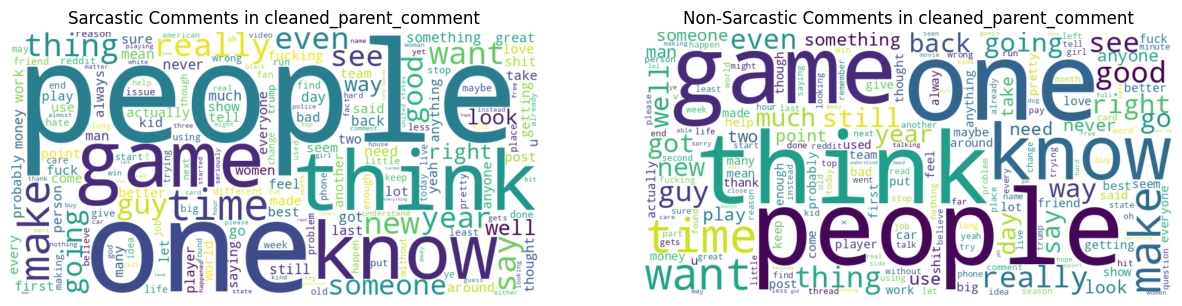

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join lists of words in cleaned_comment column to form strings
sarcastic_comments = ' '.join(df[df['label'] == 1]['cleaned_comment'].apply(lambda x: ' '.join(x)))
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['cleaned_comment'].apply(lambda x: ' '.join(x)))

# Generate word clouds for sarcastic and non-sarcastic comments in cleaned_comment
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds for cleaned_comment
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments in cleaned_comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in cleaned_comment')
plt.axis('off')

plt.show()

# Join lists of words in cleaned_parent_comment column to form strings
sarcastic_parent_comments = ' '.join(df[df['label'] == 1]['cleaned_parent_comment'].apply(lambda x: ' '.join(x)))
non_sarcastic_parent_comments = ' '.join(df[df['label'] == 0]['cleaned_parent_comment'].apply(lambda x: ' '.join(x)))

# Generate word clouds for sarcastic and non-sarcastic comments in cleaned_parent_comment
wordcloud_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_parent_comments)
wordcloud_non_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_parent_comments)

# Plot the word clouds for cleaned_parent_comment
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic_parent, interpolation='bilinear')
plt.title('Sarcastic Comments in cleaned_parent_comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic_parent, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in cleaned_parent_comment')
plt.axis('off')

plt.show()

**GloVe Embedding**

In [42]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [43]:
import spacy
import numpy as np

# Load SpaCy with GloVe vectors
nlp = spacy.load("en_core_web_md")  # Load the medium-sized English model with GloVe vectors

# Define function to compute average GloVe embeddings for a text
def compute_average_glove_embedding(text, nlp_model):
    doc = nlp_model(' '.join(text))
    # Get vectors for each token in the text
    word_vectors = [token.vector for token in doc if not token.is_stop]
    if word_vectors:
        # Compute average embedding
        average_embedding = np.mean(word_vectors, axis=0)
        return average_embedding
    else:
        # Return zeros if no valid word vectors found
        return np.zeros(nlp_model.vocab.vectors_length)

# Compute average GloVe embeddings for each comment
df['glove_embedding'] = df['cleaned_comment'].apply(lambda x: compute_average_glove_embedding(x, nlp))
df['glove_parent_embedding'] = df['cleaned_parent_comment'].apply(lambda x: compute_average_glove_embedding(x, nlp))


In [44]:
df.head(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment,cleaned_comment,cleaned_parent_comment,glove_embedding,glove_parent_embedding
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,And he sure as hell is successful!,[],...,False,False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","['Obama', 'is', 'smoked', 'before', '?', 'Or',...","['and', 'he', 'sure', 'as', 'hell', 'is', 'suc...","['obama', 'is', 'smoked', 'before', '?', 'or',...","[sure, hell, successful, !]","[obama, smoked, ?, least, admitted, ?]","[1.116775, 0.205675, -2.4696097, -1.0811, 2.54...","[-2.21133, 2.9724898, -4.5425696, 1.7032042, 1..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",[],...,False,False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","['You', 'can', 'say', 'the', 'same', 'thing', ...","['wait', 'you', 'have', 'to', 'win', 'the', 'c...","['you', 'can', 'say', 'the', 'same', 'thing', ...","[wait, win, candidates, challenge, world, titl...","[say, thing, chess, player, end, day, win, can...","[-1.0515015, 1.8250101, -0.5487285, 0.2253029,...","[-0.8147202, 1.8523735, -0.5417, 0.4942483, 2...."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?,I mean how could anyone not see that it is ant...,[],...,False,False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","['That', 'is', 'not', 'Hanako', '?']","['I', 'mean', 'how', 'could', 'anyone', 'not',...","['that', 'is', 'not', 'hanako', '?']","[mean, could, anyone, not, see, antique, shopguy]","[not, hanako, ?]","[-1.5973034, -1.8116966, 0.23922665, 0.2648633...","[-1.99855, 3.2357, -3.91745, 0.133095, 0.33051..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",[],...,False,False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","['Girl', 'Pants', 'Xpost', 'from', 'TwoXChromo...","['funny', 'thing', 'most', 'of', 'the', 'girl'...","['girl', 'pants', 'xpost', 'from', 'twoxchromo...","[funny, thing, girl, pants, bought, pretty, go...","[girl, pants, xpost, twoxchromosomes]","[-0.7506935, 0.79083985, -2.4117038, -0.75068,...","[0.22152749, 1.6525, -2.2233, -1.371625, -0.37..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",[LBJ],...,False,False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","['Lyndon', 'Johnson', 'salad', 'A', 'carrot', ...","['also', 'ranch', 'dressing', 'because', 'LBJ'...","['lyndon', 'johnson', 'salad', 'A', 'carrot', ...","[also, ranch, dressing, LBJ, texan, not, take,...","[lyndon, johnson, salad, carrot, beetroots, sh...","[-0.17442994, -0.68853503, -1.491125, -0.86793...","[0.4102414, 0.1486657, -2.097834, 1.2666999, -..."
951335,0,Being adorable.,ParisPC07,3,2013-10-16 19:21:43,What is this little red spider doing?,Being adorable.,What is this little red spider doing?,Being adorable.,[],...,False,False,"['Being', 'adorable']","['What', 'is', 'this', 'little', 'red', 'spide.

**lemmetization**

In [45]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

def lemma(comment):
    # Join the list of words into a single string
    text = ' '.join(comment)
    # Tokenize the text
    words = word_tokenize(text)
    # Lemmatize and remove stopwords
    cleaned_words = [token.lemma_ for token in nlp(' '.join(words)) if token.text not in stops]
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply lemmatization
df["lemma_comment"] = df["cleaned_comment"].apply(lemma)
df["lemma_parent_comment"] = df["cleaned_parent_comment"].apply(lemma)

In [46]:
df.head(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment,cleaned_comment,cleaned_parent_comment,glove_embedding,glove_parent_embedding,lemma_comment,lemma_parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,Obama is smoked before? Or at least admitted it?,And he sure as hell is successful!,[],...,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","['Obama', 'is', 'smoked', 'before', '?', 'Or',...","['and', 'he', 'sure', 'as', 'hell', 'is', 'suc...","['obama', 'is', 'smoked', 'before', '?', 'or',...","[sure, hell, successful, !]","[obama, smoked, ?, least, admitted, ?]","[1.116775, 0.205675, -2.4696097, -1.0811, 2.54...","[-2.21133, 2.9724898, -4.5425696, 1.7032042, 1...",sure hell successful !,obama smoke ? least admit ?
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...",[],...,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","['You', 'can', 'say', 'the', 'same', 'thing', ...","['wait', 'you', 'have', 'to', 'win', 'the', 'c...","['you', 'can', 'say', 'the', 'same', 'thing', ...","[wait, win, candidates, challenge, world, titl...","[say, thing, chess, player, end, day, win, can...","[-1.0515015, 1.8250101, -0.5487285, 0.2253029,...","[-0.8147202, 1.8523735, -0.5417, 0.4942483, 2....",wait win candidate challenge world title ?,say thing chess player end day win candidate t...
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,That is not Hanako?,I mean how could anyone not see that it is ant...,[],...,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","['That', 'is', 'not', 'Hanako', '?']","['I', 'mean', 'how', 'could', 'anyone', 'not',...","['that', 'is', 'not', 'hanako', '?']","[mean, could, anyone, not, see, antique, shopguy]","[not, hanako, ?]","[-1.5973034, -1.8116966, 0.23922665, 0.2648633...","[-1.99855, 3.2357, -3.91745, 0.133095, 0.33051...",mean could anyone not see antique shopguy,not hanako ?
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...",[],...,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","['Girl', 'Pants', 'Xpost', 'from', 'TwoXChromo...","['funny', 'thing', 'most', 'of', 'the', 'girl'...","['girl', 'pants', 'xpost', 'from', 'twoxchromo...","[funny, thing, girl, pants, bought, pretty, go...","[girl, pants, xpost, twoxchromosomes]","[-0.7506935, 0.79083985, -2.4117038, -0.75068,...","[0.22152749, 1.6525, -2.2233, -1.371625, -0.37...",funny thing girl pant buy pretty good pocket n...,girl pant xpost twoxchromosome
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",Lyndon Johnson salad: A carrot and beetroots...,"Also Ranch dressing, because LBJ was Texan, an...",[LBJ],...,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","['Lyndon', 'Johnson', 'salad', 'A', 'carrot', ...","['also', 'ranch', 'dressing', 'because', 'LBJ'...","['lyndon', 'johnson', 'salad', 'A', 'carrot', ...","[also, ranch, dressing, LBJ, texan, not, take,...","[lyndon, johnson, salad, carrot, beetroots, sh...","[-0.17442994, -0.68853503, -1.491125, -0.86793...","[0.4102414, 0.1486657, -2.097834, 1.2666999, -...",also ranch dress LBJ texan n

**TF-IDF Vectorization**

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer for 'lemma_comment'
vectorizer_comment = TfidfVectorizer()
TfIdfMatrix_comment = vectorizer_comment.fit_transform(df["lemma_comment"])
print(TfIdfMatrix_comment)
print("----------------------------------------------------------")
# Create TF-IDF vectorizer for 'lemma_parent_comment'
vectorizer_parent_comment = TfidfVectorizer()
TfIdfMatrix_parent_comment = vectorizer_parent_comment.fit_transform(df["lemma_parent_comment"])
print(TfIdfMatrix_parent_comment)

  (0, 9571)	0.7117831377662319
  (0, 4484)	0.5722237846510644
  (0, 9645)	0.40733856320175443
  (1, 10036)	0.4234434890488435
  (1, 10989)	0.3554569772769603
  (1, 1593)	0.46467010176552276
  (1, 1451)	0.4766054789515363
  (1, 10910)	0.3627865379868629
  (1, 10704)	0.34592020857615513
  (2, 8930)	0.5563870831803763
  (2, 396)	0.5326833320808834
  (2, 8748)	0.27093534115221457
  (2, 6801)	0.15806872806828584
  (2, 408)	0.3705960114730136
  (2, 2159)	0.29267933410636043
  (2, 6115)	0.29204041361119737
  (3, 6970)	0.10530061477780081
  (3, 8832)	0.23145456368098216
  (3, 5527)	0.21459766171308026
  (3, 8039)	0.17670456798801218
  (3, 8070)	0.13631663316901313
  (3, 3582)	0.13970339875463073
  (3, 2650)	0.19487635065396966
  (3, 6931)	0.19231404940894858
  (3, 10703)	0.23145456368098216
  :	:
  (9992, 772)	0.9091001720184941
  (9992, 4092)	0.4165775764919955
  (9993, 3925)	0.7071067811865476
  (9993, 9190)	0.7071067811865476
  (9994, 1902)	0.5256546890042357
  (9994, 7709)	0.43280739446998

**Concatinating GloVe Embedding Matrices and Tf-Idf Vectors horizontaly to create single feature Matrices**

In [48]:
from scipy.sparse import hstack, csr_matrix

# Convert the GloVe embeddings to CSR matrices for lemma_comment
glove_embeddings_comment = csr_matrix(np.vstack(df["glove_embedding"].values))
glove_embeddings_parent_comment = csr_matrix(np.vstack(df["glove_parent_embedding"].values))

# Combine the TF-IDF matrix and the GloVe embeddings for lemma_comment horizontally
combined_matrix_comment = hstack([TfIdfMatrix_comment, glove_embeddings_comment])

# Combine the TF-IDF matrix and the GloVe embeddings for lemma_parent_comment horizontally
combined_matrix_parent_comment = hstack([TfIdfMatrix_parent_comment, glove_embeddings_parent_comment])

# Print the shapes of the matrices
print("Combined matrix for lemma_comment shape:")
print("TfIdfMatrix shape:", TfIdfMatrix_comment.shape)
print("GloVe embeddings after csr shape:", glove_embeddings_comment.shape)
print("Combined matrix shape:", combined_matrix_comment.shape)

print("\nCombined matrix for lemma_parent_comment shape:")
print("TfIdfMatrix shape:", TfIdfMatrix_parent_comment.shape)
print("GloVe embeddings after csr shape:", glove_embeddings_parent_comment.shape)
print("Combined matrix parent shape:", combined_matrix_parent_comment.shape)

Combined matrix for lemma_comment shape:
TfIdfMatrix shape: (10000, 11187)
GloVe embeddings after csr shape: (10000, 300)
Combined matrix shape: (10000, 11487)

Combined matrix for lemma_parent_comment shape:
TfIdfMatrix shape: (10000, 17549)
GloVe embeddings after csr shape: (10000, 300)
Combined matrix parent shape: (10000, 17849)


In [49]:
print(combined_matrix_comment)
print("---------------------------------------------------")
print(combined_matrix_parent_comment)

  (0, 9571)	0.7117831377662319
  (0, 4484)	0.5722237846510644
  (0, 9645)	0.40733856320175443
  (0, 11187)	1.1167750358581543
  (0, 11188)	0.20567500591278076
  (0, 11189)	-2.4696097373962402
  (0, 11190)	-1.0810999870300293
  (0, 11191)	2.5414748191833496
  (0, 11192)	2.939802646636963
  (0, 11193)	1.2601025104522705
  (0, 11194)	1.6486749649047852
  (0, 11195)	-2.6000325679779053
  (0, 11196)	1.4555723667144775
  (0, 11197)	0.8994225859642029
  (0, 11198)	0.2915574908256531
  (0, 11199)	-1.5501799583435059
  (0, 11200)	3.6577248573303223
  (0, 11201)	2.2925374507904053
  (0, 11202)	-2.489224910736084
  (0, 11203)	1.2132599353790283
  (0, 11204)	-2.13112735748291
  (0, 11205)	-0.9687325358390808
  (0, 11206)	-1.1257050037384033
  (0, 11207)	2.1764025688171387
  (0, 11208)	0.10024247318506241
  :	:
  (9999, 11462)	0.20925500988960266
  (9999, 11463)	-0.39134499430656433
  (9999, 11464)	-0.1356000304222107
  (9999, 11465)	-0.8202250003814697
  (9999, 11466)	4.329050064086914
  (9999, 11

# RF Classifier

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Combine the TF-IDF matrix and the GloVe embeddings for lemma_comment and lemma_parent_comment horizontally
combined_matrix_combined = hstack([combined_matrix_comment, combined_matrix_parent_comment])

#'labels' is a binary column indicating sarcasm (1) or not sarcasm (0)
X = combined_matrix_combined
y = df["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf_classifier.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_classifier.predict(X_train)

# Make predictions on the test set
y_test_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model on training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Calculate the accuracy of the model on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 1.0
Test Accuracy: 0.5855


**Evaluating the RF Classifier**

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.5855
Precision: 0.5903225806451613
Recall: 0.5506519558676028
F1-score: 0.5697976128697457
Confusion Matrix:
 [[622 381]
 [448 549]]


Class Seperability

In [52]:
# Calculate the F1 score for both the training and test sets
f1_score_train = f1_score(y_train, y_train_pred)
f1_score_test = f1_score(y_test, y_test_pred)

# Calculate the inverse of the F1 score, as smaller F1 scores indicate better separability
train_separability_f1 = 1 / f1_score_train
test_separability_f1 = 1 / f1_score_test

print(f'Training class separability (F1 score): {train_separability_f1}')
print(f'Test class separability (F1 score): {test_separability_f1}')

Training class separability (F1 score): 1.0
Test class separability (F1 score): 1.7550091074681238


Training class separability of 1.0: Perfect separation on training data, indicating flawless classification between classes in the training set.

Test class separability of 1.755: Indicates good separation on test data, but not perfect. A value over 1 implies F1 score less than 1, suggesting some misclassifications, yet the model generally distinguishes classes well in the test set.

**Model Interpretability using LIME (Local Interpretable Model-agnostic Explanations):**

In [53]:
# Check the type of values in the label column
label_types = set()
for val in df["label"]:
    label_types.add(type(val))

print("Types present in label column:", label_types)

# Check if the label column has values other than 0 and 1
unique_values = set(df["label"])
if len(unique_values - {0, 1}) > 0:
    print("Label column has values other than 0 and 1.")
else:
    print("Label column only has values 0 and 1.")


Types present in label column: {<class 'int'>}
Label column only has values 0 and 1.


In [54]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=40639bf64157f65afaf458eebf3e810030c4b1d7c01fab0cce8671516d0d3f4b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [55]:
from lime import lime_tabular

# Convert feature names to strings
feature_names_str = [str(i) for i in range(X_train.shape[1])]

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(X_train.toarray(),
                                              feature_names=feature_names_str,
                                              class_names=['Non-Sarcastic', 'Sarcastic'],
                                              discretize_continuous=True)

# Define explanation function
def explain_prediction(instance_index):
    instance = X_test.toarray()[instance_index]
    explanation = explainer.explain_instance(instance, rf_classifier.predict_proba, num_features=10)
    explanation.show_in_notebook()

# Explain predictions for a specific instance (change instance_index accordingly)
instance_index = 140  # Change this index to explain predictions for different instances
explain_prediction(instance_index)

KeyboardInterrupt: 

# LSTM Model

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D

#'labels' is a binary column indicating sarcasm (1) or not sarcasm (0)
X = combined_matrix_combined
y = df["label"]
y = y.reset_index(drop=True)
print("Shape of X:", X.shape)

# Convert sparse matrix X to a dense array
X_dense = X.toarray()
print(X_dense)

In [ ]:
# Reshape X for LSTM input
X_reshaped = np.reshape(X_dense, (10000, 29336, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Define LSTM model
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
LSTMmodel.add(Dense(1, activation='sigmoid'))

# Compile the model
LSTMmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
LSTMmodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
250/250 [==============================] - 231s 896ms/step - loss: 0.6927 - accuracy: 0.5188 - val_loss: 0.6916 - val_accuracy: 0.5280
Epoch 2/10
250/250 [==============================] - 217s 869ms/step - loss: 0.6915 - accuracy: 0.5304 - val_loss: 0.6915 - val_accuracy: 0.5190
Epoch 3/10
250/250 [==============================] - 219s 875ms/step - loss: 0.6910 - accuracy: 0.5259 - val_loss: 0.6922 - val_accuracy: 0.5230
Epoch 4/10
250/250 [==============================] - 219s 875ms/step - loss: 0.6904 - accuracy: 0.5276 - val_loss: 0.6918 - val_accuracy: 0.5260
Epoch 5/10
250/250 [==============================] - 219s 875ms/step - loss: 0.6899 - accuracy: 0.5291 - val_loss: 0.6912 - val_accuracy: 0.5285
Epoch 6/10
250/250 [==============================] - 219s 875ms/step - loss: 0.6901 - accuracy: 0.5305 - val_loss: 0.6907 - val_accuracy: 0.5315
Epoch 7/10
250/250 [==============================] - 218s 874ms/step - loss: 0.6899 - accuracy: 0.5350 - val_loss: 0.6907 -

In [ ]:
# Make predictions on the training set
y_train_predlstm = LSTMmodel.predict(X_train)

# Make predictions on the test set
y_test_predlstm = LSTMmodel.predict(X_test)

# Round the predictions to the nearest integer
y_train_predlstm_rounded = np.round(y_train_predlstm).astype(int)
y_test_predlstm_rounded = np.round(y_test_predlstm).astype(int)

# Calculate the accuracy of the model on training set
train_accuracy = accuracy_score(y_train, y_train_predlstm_rounded)
print("Train Accuracy:", train_accuracy)

# Calculate the accuracy of the model on test set
test_accuracy = accuracy_score(y_test, y_test_predlstm_rounded)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 20s 312ms/step
Train Accuracy: 0.537375
Test Accuracy: 0.539
